In [1]:
import numpy as np, matplotlib.pyplot as plt

In [23]:
def generate(l,posterior):
    '''
    generate data X=(x1,x2) and Y according to posterior distribution
    input:  
            l - scalar, size of training data set
            posterior - function according to which labels +1, -1 are drawn
    output:
            X - l data points, drawn from uniform distribution in [-1,1]x[-1,1]
            Y - l labels 
    '''
    X=2*np.random.rand(l,2)-1;#uniform in [-1,1]x[-1,1]
    Y=np.zeros(l)
    for i in range(l):
        p=posterior(X[i,:])
        Y[i]=np.random.choice([-1,1], 1, p=[1-p,p])
    return X,Y

In [24]:
def empiricalrisk(l, decarray, Y):
    '''
    computes empirical risk
    input:
            l - scalar, size of training data set
            decarray - array of labels chosen by decision function
            Y - labels
    output:
            risk - empirical risk
    
    '''
    risk=(2*l)**(-1)*sum(abs(decarray-Y))
    return risk

In [25]:
def bruteforce(l,X,Y):
    '''
    brute force approach to find class optimal decision function 
    input: 
            l - scalar, size of training data set
            X - l data points
            Y - l labels
    output: 
            minrisk - minimal empirical risk
            optimalclassifier - array with entries: w, theta, case 1 or 2 (ie sign + or -)
    '''
    #pick d=2 points from X that determine hyperplane
    minrisk=1
    for i in range(l):
        for j in range(i+1,l):
                #2 points that determine classifier
                x1=X[i,:]
                x2=X[j,:]
                
                slope=(x2[1]-x1[1])/(x2[0]-x1[0])
                theta=x1[1]-x1[0]*slope
                w=np.array([slope,-1])
                #classify points
                classifier1=np.zeros(l)
                for k in range(l):
                    if np.dot(w,X[k,:])>-theta:
                        classifier1[k] = +1
                    else:
                        classifier1[k] = -1
                classifier2 = - classifier1
                
                #empirical risk
                risk1=empiricalrisk(l,classifier1,Y)
                risk2=empiricalrisk(l,classifier2,Y)
                if risk1<minrisk:
                    minrisk = risk1
                    optimalclassifier=np.array([w[0],w[1],theta,1])
                if risk2<minrisk:
                    minrisk = risk2
                    optimalclassifier=np.array([w[0],w[1],theta,2])
    return minrisk,optimalclassifier
                

In [26]:
def classifier(x,w,theta,case):
    '''classifies x into +1 or -1 '''
    if np.dot(w,x)>-theta:
        label=1*(case==1)-1*(case==2)
    else:
        label=-1*(case==1)+1*(case==2)
    return label

In [27]:
def pocket_perceptron_learning(data,labels,extended = True, max_iter=10**5):
    '''
    
    Perceptron learning algorithm for binary {+/- 1} labeled data. Terminates automatically, if the data is separated
    linearly, else runs for a maximum number of iterations and returns last stored iterate of (almost) separating
    hyperplane or separating hyperplane classifying the biggest number of points correctly (pocket algorithm).
    
    Inputs:
        data: 2d numpy array
        labels: {+1,-1} list/array classifying each data row
        max_iter: maximal number of iterations
        
    Outputs:
        w: weight vector in extended feature space defining separating hyperplane
        iterate_count: number of iterations needed until termination (an iteration is a modification of w)
        log: list number of correctly classified data rows in each iteration step
    '''
    iterate_count = 0
    active_label = 0
    n_correct = 0
    log=[0] #initial "correctly classified" log entry 
    n = data.shape[0];
    if extended: 
        data = np.c_[ data, np.ones(data.shape[0]) ] # embed data into extended n+1 dimensional extended feature space
    w = np.random.rand(data.shape[1])*10
    
    w_pocket = w; #pocket
    n_pocket = 0; #the number of succesful pocket iterations
        
    while True:
        #weight update iteration
        
        #break condition
        if n_correct >= n or iterate_count >= max_iter:
            log.append(n_pocket);
            break;
        
        #choosing next data point
        x = data[int(active_label)];
        
        #add/subtract weight modification routine
        if np.dot(x,w) <=0 and labels[active_label]>0:
            w = w + x
            log.append(n_pocket)
            iterate_count += 1
            active_label = 0
            n_correct = 0
        elif np.dot(x,w) >=0 and labels[active_label]<0:
            w = w - x
            log.append(n_pocket)
            iterate_count += 1
            active_label = 0
        else:
            active_label += 1
            n_correct += 1
        
        #check if pocket needs to be updated
        if n_correct>n_pocket:
            n_pocket = n_correct;
            w_pocket = w;
    #return
    return w_pocket,iterate_count,log[1:]  

In [31]:
#function that determines label according X=(x1,x2)
g = lambda x: ((x[0]+1)/2) #task 3(a)
f = lambda x: 0.25*(x[0]+1)*(x[1]+1) #task 3(d)



def compare(l,posterior):
    '''to compare the brute force approach and pocket algorithm for l training data and a chosen posterior'''
    
    #generate training data X,Y
    X,Y=generate(l,posterior) 

    #empirical risk minimization: brute force approach
    minrisk,optclassifier=bruteforce(l,X,Y) 
    #optimal classifier function
    opclassifierfun= lambda x: classifier(x,optclassifier[0:2],optclassifier[2],optclassifier[3])
    #labels according to optimal classifier function
    classifierbruteforce = np.array([opclassifierfun(X[i,:]) for i in range(l)])

    #Pocket Algorithm
    w,iter_count,log=pocket_perceptron_learning(X,Y,max_iter=10**5)
    #labels according to Pocket Algorithm
    classifierpocket = np.array([classifier(np.array([X[i,0],X[i,1]]),w[0:2],-w[2],1) for i in range(l)])
    #empirical risk according to Pocket Algorithm
    riskpocket = empiricalrisk(l,classifierpocket,Y)
    
    return X,Y, minrisk, classifierbruteforce, riskpocket, classifierpocket

In [30]:
#RESULTS

results=np.zeros((10,5))
count=0
for l in range(10,101,10):#(10,101,10): #size of training set
    for k in range(10): #repeat and average
        Xg,Yg, minriskg, classifierbruteforceg, riskpocketg, classifierpocketg = compare(l,g)
        Xf,Yf, minriskf, classifierbruteforcef, riskpocketf, classifierpocketf = compare(l,f)
        results[count,:]+=0.1*np.array([l,minriskg, riskpocketg, minriskf, riskpocketf])
    count+=1
print(results)    

[[  1.00000000e+01   1.60000000e-01   3.30000000e-01   8.00000000e-02
    4.00000000e-01]
 [  2.00000000e+01   1.50000000e-01   3.35000000e-01   1.20000000e-01
    5.00000000e-01]
 [  3.00000000e+01   1.53333333e-01   3.23333333e-01   1.30000000e-01
    5.90000000e-01]
 [  4.00000000e+01   1.80000000e-01   3.85000000e-01   1.57500000e-01
    5.40000000e-01]
 [  5.00000000e+01   2.04000000e-01   3.28000000e-01   1.44000000e-01
    5.74000000e-01]
 [  6.00000000e+01   1.83333333e-01   3.05000000e-01   1.95000000e-01
    4.78333333e-01]
 [  7.00000000e+01   1.82857143e-01   3.05714286e-01   1.54285714e-01
    5.62857143e-01]
 [  8.00000000e+01   2.07500000e-01   3.56250000e-01   1.75000000e-01
    5.51250000e-01]
 [  9.00000000e+01   1.92222222e-01   3.23333333e-01   1.53333333e-01
    5.46666667e-01]
 [  1.00000000e+02   2.04000000e-01   3.44000000e-01   1.61000000e-01
    4.99000000e-01]]
10


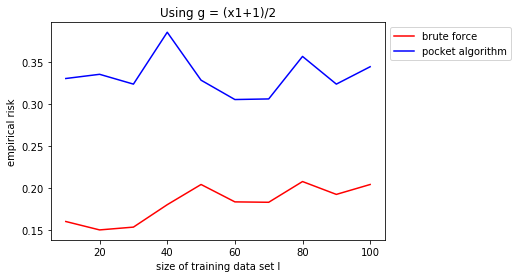

In [39]:
plt.plot(range(10,101,10),results[:,1],'r')
plt.plot(range(10,101,10),results[:,2],'b')
plt.title('Using g = (x1+1)/2')
plt.xlabel('size of training data set l')
plt.ylabel('empirical risk')
plt.legend(['brute force','pocket algorithm'], bbox_to_anchor=(1, 1), loc=2)
plt.show()

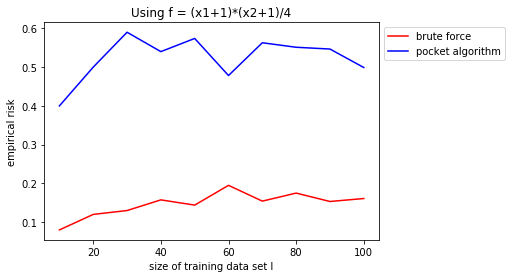

In [40]:
plt.plot(range(10,101,10),results[:,3],'r')
plt.plot(range(10,101,10),results[:,4],'b')
plt.title('Using f = (x1+1)*(x2+1)/4')
plt.xlabel('size of training data set l')
plt.ylabel('empirical risk')
plt.legend(['brute force','pocket algorithm'], bbox_to_anchor=(1, 1), loc=2)
plt.show()